### Student Information
Name: 黃恩平

Student ID: 111033622

GitHub ID: npinghuang

---

### Instructions

1. First: do the **take home** exercises in the [DM2022-Lab1-Master](https://github.com/keziatamus/DM2022-Lab1-Master). You may need to copy some cells from the Lab notebook to this notebook. __This part is worth 20% of your grade.__


2. Second: follow the same process from the [DM2022-Lab1-Master](https://github.com/keziatamus/DM2022-Lab1-Master) on **the new dataset**. You don't need to explain all details as we did (some **minimal comments** explaining your code are useful though).  __This part is worth 30% of your grade.__
    - Download the [the new dataset](https://archive.ics.uci.edu/ml/datasets/Sentiment+Labelled+Sentences#). The dataset contains a `sentence` and `score` label. Read the specificiations of the dataset for details. 
    - You are allowed to use and modify the `helper` functions in the folder of the first lab session (notice they may need modification) or create your own.


3. Third: please attempt the following tasks on **the new dataset**. __This part is worth 30% of your grade.__
    - Generate meaningful **new data visualizations**. Refer to online resources and the Data Mining textbook for inspiration and ideas. 
    - Generate **TF-IDF features** from the tokens of each text. This will generating a document matrix, however, the weights will be computed differently (using the TF-IDF value of each word per document as opposed to the word frequency). Refer to this Sciki-learn [guide](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) .
    - Implement a simple **Naive Bayes classifier** that automatically classifies the records into their categories. Use both the TF-IDF features and word frequency features to build two seperate classifiers. Comment on the differences.  Refer to this [article](https://hub.packtpub.com/implementing-3-naive-bayes-classifiers-in-scikit-learn/).


4. Fourth: In the lab, we applied each step really quickly just to illustrate how to work with your dataset. There are somethings that are not ideal or the most efficient/meaningful. Each dataset can be habdled differently as well. What are those inefficent parts you noticed? How can you improve the Data preprocessing for these specific datasets? __This part is worth 10% of your grade.__


5. Fifth: It's hard for us to follow if your code is messy, so please **tidy up your notebook** and **add minimal comments where needed**. __This part is worth 10% of your grade.__


You can submit your homework following these guidelines: [Git Intro & How to hand your homework](https://github.com/keziatamus/DM2022-Lab1-Homework/blob/main/Git%20Intro%20%26%20How%20to%20hand%20your%20homework.ipynb). Make sure to commit and save your changes to your repository __BEFORE the deadline (October 20th 11:59 pm, Thursday)__. 

## 0. The Preparation

In [122]:
### Begin Assignment Here
# TEST necessary for when working with external scripts
%load_ext autoreload
%autoreload 2
import os
import numpy as np
import pandas as pd
import sklearn
import helpers.data_mining_helpers as dmh
import nltk
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer

import matplotlib.pyplot as plt
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. The Data

In [105]:
FOLDER = 'data/'
filepath_dict = {'amazon': 'amazon_cells_labelled.txt', 'imbd'  : 'imdb_labelled.txt', 'yelp'  : 'yelp_labelled.txt'}

tmp_data = []
i = 0
for NAME, PATH in filepath_dict.items():
    tmp_data.append(pd.read_csv(FOLDER + PATH, sep = '\t', header=None, names=['sentence', 'score'], engine = 'python', quoting=3))
    # add source name to data
    tmp_data[i]['source_name'] = NAME
    i = i +1
DATA = pd.concat(tmp_data, ignore_index=True)
print(DATA.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   sentence     3000 non-null   object
 1   score        3000 non-null   int64 
 2   source_name  3000 non-null   object
dtypes: int64(1), object(2)
memory usage: 70.4+ KB
None


##### Note :
In **'imdb_labelled.txt'**, there are many sentences with only one **"**. Which **pandas** need to scan another **"** for it to function properly. To fix this, I found a solution on [stackoverflow](https://stackoverflow.com/questions/55010807/pandas-errors-parsererror-expected-after). By adding **quoting=3**, the issue is solved.

## 2. Data Mining using Pandas
### 2.1 Missing Values

In [106]:
#check missing values
DATA.isnull().apply(lambda x: dmh.check_missing_values(x), axis = 0)

,sentence,score,source_name
0,The amoung of missing records is:,The amoung of missing records is:,The amoung of missing records is:
1,0,0,0


In [107]:
DATA.isnull().apply(lambda x: dmh.check_missing_values(x), axis = 1)


0       (The amoung of missing records is: , 0)
1       (The amoung of missing records is: , 0)
2       (The amoung of missing records is: , 0)
3       (The amoung of missing records is: , 0)
4       (The amoung of missing records is: , 0)
                         ...                   
2995    (The amoung of missing records is: , 0)
2996    (The amoung of missing records is: , 0)
2997    (The amoung of missing records is: , 0)
2998    (The amoung of missing records is: , 0)
2999    (The amoung of missing records is: , 0)
Length: 3000, dtype: object

### 2.2 Duplicate Data

In [108]:
print(DATA[DATA.duplicated(keep='first')])
print(DATA[DATA.duplicated(keep='last')])

print( "number of duplicate sentences : ",sum(DATA.duplicated('sentence')))
DATA.drop_duplicates(keep=False, inplace=True) # inplace applies changes directly on our dataframe
print( "number of duplicate sentences after : ",sum(DATA.duplicated('sentence')))


                                               sentence  score source_name
285                                       Great phone!.      1      amazon
407                                        Works great.      1      amazon
524                                       Works great!.      1      amazon
543                             Don't buy this product.      0      amazon
744   If you like a loud buzzing to override all you...      0      amazon
748                                       Does not fit.      0      amazon
778                               This is a great deal.      1      amazon
792                                        Great Phone.      1      amazon
892                    Excellent product for the price.      1      amazon
896                                        Great phone.      1      amazon
1363                   Definitely worth checking out.        1        imbd
1585                                 Not recommended.        0        imbd
1788                     

## 3. Data Preprocessing

### 3.1 Source distribution

imbd      994
yelp      992
amazon    980
Name: source_name, dtype: int64


<AxesSubplot:title={'center':'Source distribution'}>

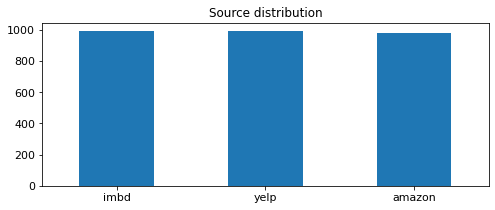

In [116]:
# categories
categories = ['amazon', 'imbd', 'yelp']
print(DATA.source_name.value_counts())
upper_bound = max(DATA.source_name.value_counts())+50
# plot barchart for DATA
DATA.source_name.value_counts().plot(kind = 'bar',
                                    title = 'Source distribution',
                                    ylim = [0, upper_bound],        
                                    rot = 0, fontsize = 11, figsize = (8,3))

### 3.2 Feature Creation

#### Tokenization of the **sentence**

In [119]:
# takes a like a minute or two to process
DATA['unigrams'] = DATA['sentence'].apply(lambda x: dmh.tokenize_text(x))

### 3.3 Feature subset selection
Heatmap

In [144]:
DATA_sample.index.to_list()

[2073,
 2559,
 1850,
 352,
 2584,
 1988,
 1539,
 2790,
 2243,
 2697,
 2681,
 2326,
 97,
 592,
 743,
 127,
 875,
 691,
 2578,
 2741,
 2427,
 416,
 22,
 765,
 2822]

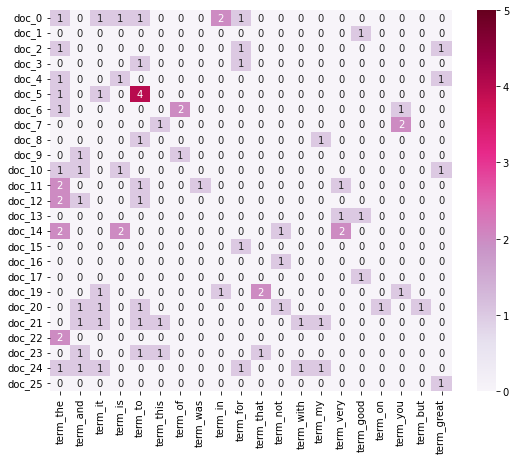

In [146]:
count_vect = CountVectorizer()

DATA_counts = count_vect.fit_transform(DATA.sentence) #learn the vocabulary and return document-term matrix
SIZE = 25
pd_counts = pd.DataFrame(DATA_counts.toarray())
# sum up each column
counts_sum = pd_counts.sum()
# sort into ascending order according to counts_sum
pd_counts = pd_counts[counts_sum.sort_values(ascending=False).index[:20]]

# first twenty features only
plot_x = ["term_"+str(i) for i in count_vect.get_feature_names_out()[pd_counts.columns[:20]]]
# obtain document index
plot_y = ["doc_"+ str(i) for i in list(DATA.index)[0:SIZE]]
plot_z = (pd_counts[0:SIZE][pd_counts.columns[:SIZE]]).to_numpy()


df_todraw = pd.DataFrame(plot_z, columns = plot_x, index = plot_y)
plt.subplots(figsize=(9, 7))
ax = sns.heatmap(df_todraw,
                 cmap="PuRd",
                 vmin=0, vmax=5, annot=True)



In [ ]:
count_vect = CountVectorizer()
SIZE = 25
DATA_sample = DATA.sample(n = SIZE)
DATA_counts = count_vect.fit_transform(DATA.sentence) #learn the vocabulary and return document-term matrix

pd_counts = pd.DataFrame(DATA_counts.toarray())
# sum up each column
counts_sum = pd_counts.sum()
# sort into ascending order according to counts_sum
pd_counts = pd_counts[counts_sum.sort_values(ascending=False).index[:20]]

# first twenty features only
plot_x = ["term_"+str(i) for i in count_vect.get_feature_names_out()[pd_counts.columns[:20]]]
# obtain document index
plot_y = ["doc_"+ str(i) for i in list(DATA_sample.index)[0:SIZE]]
plot_z = (pd_counts[DATA_sample.index.to_list()][pd_counts.columns[:SIZE]]).to_numpy()


df_todraw = pd.DataFrame(plot_z, columns = plot_x, index = plot_y)
plt.subplots(figsize=(9, 7))
ax = sns.heatmap(df_todraw,
                 cmap="PuRd",
                 vmin=0, vmax=5, annot=True)

